In [1]:
# To use the files in the parent directory run this cell
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.models.vqvae import VQVAE
# from src.models.full_vqvae import VQVAE
from src.models.var import VAR
from src.datasets.hugging_face_dataset import HuggingFaceDataset

In [6]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm


model_params = {
    "mnist": {
        "VQVAE_DIM": 64,
        "VOCAB_SIZE": 32,
        "PATCH_SIZES": [1, 2, 3, 4, 8],
        "VAR_DIM": 64,
        "N_HEADS": 4,
        "N_LAYERS": 6,
        "channels": 1,
    },
    "cifar": {
        "VQVAE_DIM": 512,
        "VOCAB_SIZE": 2048,
        "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
        "VAR_DIM": 512,
        "N_HEADS": 16,
        "N_LAYERS": 12,
        "channels": 3,
    },
    "small": {
        "VQVAE_DIM": 128,
        "VOCAB_SIZE": 4096,
        "PATCH_SIZES": [1, 2, 3, 4, 6, 8, 16],
        "VAR_DIM": 512,
        "N_HEADS": 16,
        "N_LAYERS": 16,
        "channels": 3,
    },
    # "medium": {
    #     "VQVAE_DIM": 512,
    #     "VOCAB_SIZE": 2048,
    #     "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
    #     "VAR_DIM": 512,
    #     "N_HEADS": 32,
    #     "N_LAYERS": 20,
    #     "channels": 3,
    # },
    # "large": {
    #     "VQVAE_DIM": 512,
    #     "VOCAB_SIZE": 4096,
    #     "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
    #     "VAR_DIM": 512,
    #     "N_HEADS": 64,
    #     "N_LAYERS": 24,
    #     "channels": 3,
    # },
}

training_params = {
    "mnist": {
        "VQVAE": {
            "batch_size": 2048,
            "lr": 3e-4,
            "epochs": 40,
        },
        "VAR": {
            "batch_size": 1024,
            "lr": 1e-3,
            "epochs": 100,
        },
    },
    "cifar": {
        "VQVAE": {
            "batch_size": 128,
            "lr": 1e-4,
            "epochs": 100,
        },
        "VAR": {
            "batch_size": 64,
            "lr": 1e-4,
            "epochs": 100,
        },
    },
}


def get_data(batch_size=1024, dataset="mnist"):
    if dataset == "cifar":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        train_ds = datasets.CIFAR10(
            root="./data", train=True, download=True, transform=transform
        )
        test_ds = datasets.CIFAR10(
            root="./data", train=False, download=True, transform=transform
        )
    elif dataset == "mnist":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Pad(2),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        train_ds = datasets.MNIST(
            root="./data", train=True, download=True, transform=transform
        )
        test_ds = datasets.MNIST(
            root="./data", train=False, download=True, transform=transform
        )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((32, 32)),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        # Use HuggingFace datasets
        train_ds = HuggingFaceDataset(dataset_path=dataset, split="train", transform=transform)
        test_ds = HuggingFaceDataset(dataset_path=dataset, split="val", transform=transform)


    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, drop_last=True
    )

    print(len(train_loader), len(test_loader))

    return train_loader, test_loader


def plot_images(pred, original=None):
    n = pred.size(0)
    pred = pred * 0.5 + 0.5
    pred = pred.clamp(0, 1)
    img = pred.cpu().detach()

    if original is not None:
        original = original * 0.5 + 0.5
        original = original.clamp(0, 1)
        original = original.cpu().detach()
        img = torch.cat([original, img], dim=0)

    img_grid = make_grid(img, nrow=n)
    img_grid = img_grid.permute(1, 2, 0).numpy()
    img_grid = (img_grid * 255).astype("uint8")
    plt.imshow(img_grid)
    plt.axis("off")


In [7]:
dataset = "zzsi/afhq64_16k"
model_params = model_params["small"]
training_params = training_params["cifar"]

# Training VQVAE

In [8]:
from datetime import datetime

print("=" * 10 + "Training VQVAE" + "=" * 10)

def print_latent_stats(latents, name="Latents"):
    mean_val = latents.mean().item()
    std_val = latents.std().item()
    min_val = latents.min().item()
    max_val = latents.max().item()
    print(f"{name}: mean={mean_val:.4f}, std={std_val:.4f}, min={min_val:.4f}, max={max_val:.4f}")

# Create output directory if it doesn't exist
start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"../logs/var/vqvae/{start_time}"
os.makedirs(log_dir, exist_ok=True)


vq_model = VQVAE(
    dim=model_params["VQVAE_DIM"],
    vocab_size=model_params["VOCAB_SIZE"],
    patch_sizes=model_params["PATCH_SIZES"],
    num_channels=model_params["channels"],
)
optimizer = torch.optim.AdamW(
    vq_model.parameters(), lr=training_params["VQVAE"]["lr"]
)

train_loader, test_loader = get_data(
    batch_size=training_params["VQVAE"]["batch_size"], dataset=dataset
)
vq_model = vq_model.to("cuda")

# All epochs
for epoch in tqdm(range(training_params["VQVAE"]["epochs"])):
    epoch_loss = 0
    epoch_recon_loss = 0
    # Single epochs
    for i, (x, c) in enumerate(train_loader):
        x, c = x.cuda(), c.cuda()
        optimizer.zero_grad()

        # Optionally check and print the latent stats from the encoder on the first batch of each epoch.
        if i == 0:
            with torch.no_grad():
                latent = vq_model.encoder(x)
                print_latent_stats(latent, name=f"Epoch {epoch} Encoder Output")

        xhat, r_maps, idxs, scales, q_loss = vq_model(x)
        recon_loss = F.mse_loss(xhat, x)
        loss = recon_loss + q_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()

    epoch_loss /= len(train_loader)
    epoch_recon_loss /= len(train_loader)
    print(f"Epoch: {epoch}, Loss: {epoch_loss}, Recon Loss: {epoch_recon_loss}")

    if epoch % 5 == 0:
        with torch.no_grad():
            total_loss = 0
            total_recon_loss = 0
            for i, (x, c) in enumerate(test_loader):
                x, c = x.cuda(), c.cuda()
                xhat, r_maps, idxs, scales, q_loss = vq_model(x)
                recon_loss = F.mse_loss(xhat, x)
                loss = recon_loss + q_loss
                total_loss += loss.item()
                total_recon_loss += recon_loss.item()

            total_loss /= len(test_loader)
            total_recon_loss /= len(test_loader)

            print(
                f"Epoch: {epoch}, Test Loss: {total_loss}, Test Recon Loss: {total_recon_loss}"
            )

            x = x[:10, :].cuda()
            x_hat = vq_model(x)[0]

            plot_images(pred=x_hat, original=x)
            plt.savefig(f"{log_dir}/vqvae_{epoch}.png")
            plt.close()

torch.save(vq_model.state_dict(), f"{log_dir}/vqvae_animal_faces.pth")
del vq_model, optimizer, x, x_hat, train_loader, test_loader
gc.collect()
torch.cuda.empty_cache()


==========Training VQVAE==========
115 11


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Encoder Output: mean=0.0861, std=0.7615, min=-4.1897, max=4.1117


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 12.81 MiB is free. Including non-PyTorch memory, this process has 23.47 GiB memory in use. Of the allocated memory 22.45 GiB is allocated by PyTorch, and 725.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Training VAR

In [10]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [11]:
print("=" * 10 + "Training VAR" + "=" * 10)
vqvae = VQVAE(
    model_params["VQVAE_DIM"],
    model_params["VOCAB_SIZE"],
    model_params["PATCH_SIZES"],
    num_channels=model_params["channels"],
)
vqvae.load_state_dict(torch.load("../logs/var/vqvae/2025-02-23_11-26-09/vqvae_animal_faces.pth"))  # LOADS the trained VQVAE model
vqvae = vqvae.to("cuda")
vqvae.eval()

for param in vqvae.parameters():
    param.requires_grad = False

var_model = VAR(
    vqvae=vqvae,
    dim=model_params["VAR_DIM"],
    n_heads=model_params["N_HEADS"],
    n_layers=model_params["N_LAYERS"],
    patch_sizes=model_params["PATCH_SIZES"],
    n_classes=10,
)
optimizer = torch.optim.AdamW(
    var_model.parameters(), lr=training_params["VAR"]["lr"]
)

print(f"VQVAE Parameters: {sum(p.numel() for p in vqvae.parameters())/1e6:.2f}M")
print(f"VAR Parameters: {sum(p.numel() for p in var_model.parameters())/1e6:.2f}M")

train_loader, test_loader = get_data(
    batch_size=training_params["VAR"]["batch_size"], dataset=dataset
)
var_model = var_model.to("cuda")
for epoch in tqdm(range(training_params["VAR"]["epochs"])):
    epoch_loss = 0
    for i, (x, c) in enumerate(train_loader):
        x, c = x.cuda(), c.cuda()
        optimizer.zero_grad()

        _, _, idxs_R_BL, scales_BlC, _ = vqvae(x)
        idx_BL = torch.cat(idxs_R_BL, dim=1)
        scales_BlC = scales_BlC.cuda()
        logits_BLV = var_model(scales_BlC, cond=c)
        loss = F.cross_entropy(
            logits_BLV.view(-1, logits_BLV.size(-1)), idx_BL.view(-1)
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

    if epoch % 5 == 0:
        with torch.no_grad():

            cond = torch.arange(10).cuda()
            out_B3HW = var_model.generate(cond, 0)
            plot_images(pred=out_B3HW)

            plt.savefig(f"var_{epoch}.png")
            plt.close()
    
    if epoch % 10 == 0:
        torch.save(var_model.state_dict(), "var.pth")

torch.save(var_model.state_dict(), "var.pth")

==========Training VAR==========


/tmp/ipykernel_43419/3453378021.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load("../logs/var/vqvae/2025-02-23_11-26-09/vqvae_animal_face

VQVAE Parameters: 16.68M
VAR Parameters: 111.84M
229 23


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 832.00 KiB is free. Including non-PyTorch memory, this process has 23.48 GiB memory in use. Of the allocated memory 22.95 GiB is allocated by PyTorch, and 228.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Test Quality of VQVAE

To test the quality of the vqvae we take a ground truth image pass it through the vqvae, change a few of the tokens, and then pass it through the decoder.



In [6]:
vq_model = VQVAE(
    dim=model_params["VQVAE_DIM"],
    vocab_size=model_params["VOCAB_SIZE"],
    patch_sizes=model_params["PATCH_SIZES"],
    num_channels=model_params["channels"],
).cuda()
# vq_model.load_state_dict(torch.load("vqvae.pth"))
vq_model.load_state_dict(torch.load(f"../logs/var/vqvae/2025-02-23_11-26-09/vqvae_animal_faces.pth"))

train_loader, test_loader = get_data(
    batch_size=1, dataset=dataset
)
x = next(iter(train_loader))[0].cuda()


/tmp/ipykernel_42854/2028737188.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vq_model.load_state_dict(torch.load(f"../logs/var/vqvae/2025-02-23_11-26-09/vqvae_animal_

14630 1500


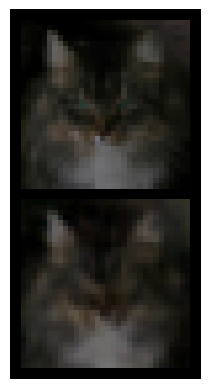

In [7]:
with torch.no_grad():
    latent = vq_model.encoder(x)
    fhat, r_maps, idxs, scales, loss = vq_model.quantizer(latent)
    x_hat = vq_model.decoder(fhat)

    plot_images(x_hat, original=x)


torch.Size([1, 256, 8, 8])
2 1
4 6
7 6
6 4
7 6
7 5
2 7
7 5


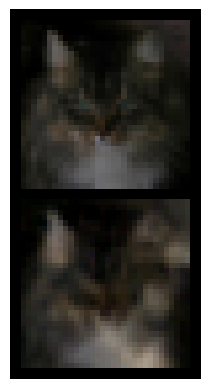

In [39]:

import random


with torch.no_grad():
    latent = vq_model.encoder(x)
    fhat, r_maps, idxs, scales, loss = vq_model.quantizer(latent)

    print(fhat.shape)

    # For 5 random patches, change the vector to a random vector from the codebook
    for i in range(8):
        random_x = random.randint(0, fhat.shape[2] - 1)
        random_y = random.randint(0, fhat.shape[3] - 1)
        print(random_x, random_y)
        new_vector = vq_model.quantizer.codebook(torch.randint(0, model_params["VOCAB_SIZE"], (1,)).cuda())
        fhat[0, :, random_x, random_y] = new_vector
    # new_vector = vq_model.quantizer.codebook(torch.tensor(500).cuda())
    # fhat[0, :, 0, 0] = new_vector

    # Decode the altered latent
    x_hat = vq_model.decoder(fhat)

    plot_images(x_hat, original=x)
